In [18]:
# !pip install gymnasium
# !pip install gymnasium[toy-text]
# !pip install tqdm #just for progress bar

In [19]:
from icecream import ic
#check versions
import gymnasium as gym
print(f'Gymnasium v{gym.__version__}')
import sys; print(f'Python v{sys.version}')

from gymnasium.envs.toy_text.frozen_lake import generate_random_map
#create env
#env=gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode='rgb_array') #specific map
#env=gym.make('FrozenLake-v1', desc=generate_random_map(4), map_name="4x4", is_slippery=True, render_mode='rgb_array')
env=gym.make('Blackjack-v1',render_mode='rgb_array')
#env=gym.make('CliffWalking-v0',render_mode='rgb_array')
#env=gym.make('Taxi-v3',render_mode='rgb_array')done=False
observation, info = env.reset()

Gymnasium v0.29.0
Python v3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]


In [20]:
# #Just some manual tests
# import matplotlib.pyplot as plt
# if terminated or truncated:
#     env.reset()
# obs, reward, terminated, truncated, info =env.step(1)
# print(obs)
# print(reward)

# img=env.render()
# fig, ax=plt.subplots()
# ax.imshow(img)
# ax.set_title('Game')
# ax.axis('off')
# plt.show()

In [21]:
import numpy as np
from collections import defaultdict

from IPython.display import clear_output
from tqdm import tqdm
from gymnasium.wrappers import RecordEpisodeStatistics
import matplotlib.pyplot as plt


class constant_learning_rate_MC:
    def __init__(
        self,
        learning_rate: float=0.8,
        initial_epsilon: float=0.0001,
        epsilon_decay: float=0.0001,
        final_epsilon: float=0.0001,
        discount_factor: float = 1,
        n_episodes: int=3000,
        env_stat: RecordEpisodeStatistics=env,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values=defaultdict(lambda: np.zeros(env.action_space.n)) #everytime new statevalue added the lambda function is called to create a np vector of q values (initialized to zero)
        self.lr = learning_rate #the bigger the more oscillations q_values
        self.discount_factor = discount_factor 
        self.epsilon = initial_epsilon 
        self.epsilon_decay = epsilon_decay #linear decay until reaches final_epsilon
        self.final_epsilon = final_epsilon #approximately zero 
        self.n_episodes= n_episodes
        self.obs_traj=[]
        self.action_traj=[]
        self.reward_traj=[]
        self.env_stat=env_stat
        self.training_error=[] #temporale differences (when small, no further improvements expected)

    def get_action(self, obs) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        if np.random.random()<self.epsilon:
            return env.action_space.sample()
        else:
            return int(np.argmax(self.q_values[obs]))

    def linear_decay(self):
        self.epsilon=max(self.final_epsilon, self.epsilon-self.epsilon_decay)
    def exponential_decay(self): 
        self.epsilon= self.epsilon*self.epsilon_decay


    def update_traj(self, obs, action, reward, terminated):
        """Append new obs, action, reward. When terminated, update policy and trash the episode"""
        self.action_traj.append(action)
        self.reward_traj.append(reward)
        self.obs_traj.append(obs)
        #ic(obs)
        if terminated:
            self.update_policy()           
            self.obs_traj=[]
            self.action_traj=[]
            self.reward_traj=[] 
    def update_policy(self):
        """Updates the Q-values from last episode using the following:
                Q(S_t, A_t)<- Q(S_t, A_t) + learning_rate*(G_t-Q(S_t,A_t)),
                where G_t is the expected return at time-step t.
        """
        G=0
        sum=0
        visited=[]
        for obs, action, reward in reversed(list(zip(self.obs_traj, self.action_traj, self.reward_traj))):
            G= G + reward
            #Update once per episode
            if (obs, action) not in visited:
                self.q_values[obs][action]= self.q_values[obs][action] + self.lr*(G - self.q_values[obs][action])
                visited.append((obs,action))
                sum+=abs(G - self.q_values[obs][action])
            #ic(visited)
        #if any(self.q_values[15]):
        #    ic(self.q_values[15])
        self.training_error.append(sum/len(visited))
    
    def train(self):
        for episode in tqdm(range(self.n_episodes)):
            obs, info = self.env_stat.reset()
            done = False
            # play one episode
            while not done:
                action = self.get_action(obs)
                next_obs, reward, terminated, truncated, info = self.env_stat.step(action)

                #update_traj at each step and update policy at the end
                self.update_traj(next_obs, action, reward, terminated)
                done= terminated or truncated
                obs=next_obs
                if info.get('TimeLimit.truncated', False):
                    done = True  # Terminate the episode if max episode steps are reached
            self.linear_decay()
            #ic(self.epsilon)
            #ic(self.q_values[0])
   
    def plot(self, rolling_length=100):
        fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
        axs[0].set_title("Episode rewards")
        reward_moving_average = (
            np.convolve(
                np.array(self.env_stat.return_queue).flatten(), np.ones(rolling_length), mode="valid"
            )
            / rolling_length
        )
        axs[0].plot(range(len(reward_moving_average)), reward_moving_average)

        axs[1].set_title("Episode lengths")
        length_moving_average = (
            np.convolve(
                np.array(self.env_stat.length_queue).flatten(), np.ones(rolling_length), mode="same"
            )
            / rolling_length
        )
        axs[1].plot(range(len(length_moving_average)), length_moving_average)

        axs[2].set_title("Training Error")
        training_error_moving_average = (
            np.convolve(np.array(self.training_error), np.ones(rolling_length), mode="same")
            / rolling_length
        )
        axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
        
        title= "learning_rate= "+str(self.lr)+ ", n_episonde= "+ str(self.n_episodes)
        plt.suptitle(title)
        plt.tight_layout()
        plt.show()



In [22]:
# hyperparameters
learning_rate = 0.8
n_episodes = 8000000
start_epsilon = 1.0
final_epsilon = 0.00001
epsilon_decay = start_epsilon/n_episodes  # reduce the exploration over time linearly
discount_factor=0.99
#epsilon_decay= final_epsilon**(1/n_episodes) #with n_episodes updates epsilon reaches 0.000001


# Define the maximum number of steps per episode
max_episode_steps = 200

from gym.wrappers import TimeLimit
# Wrap the environment with the TimeLimit wrapper
env = TimeLimit(env, max_episode_steps=max_episode_steps)

env_stat = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
agent1=constant_learning_rate_MC(
    n_episodes=n_episodes,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount_factor,
    env_stat=env_stat,)

In [23]:
agent1.train()

100%|██████████| 1000000/1000000 [02:14<00:00, 7413.75it/s]


In [1]:
import matplotlib.pyplot as plt
agent1.plot(1000)

NameError: name 'agent1' is not defined

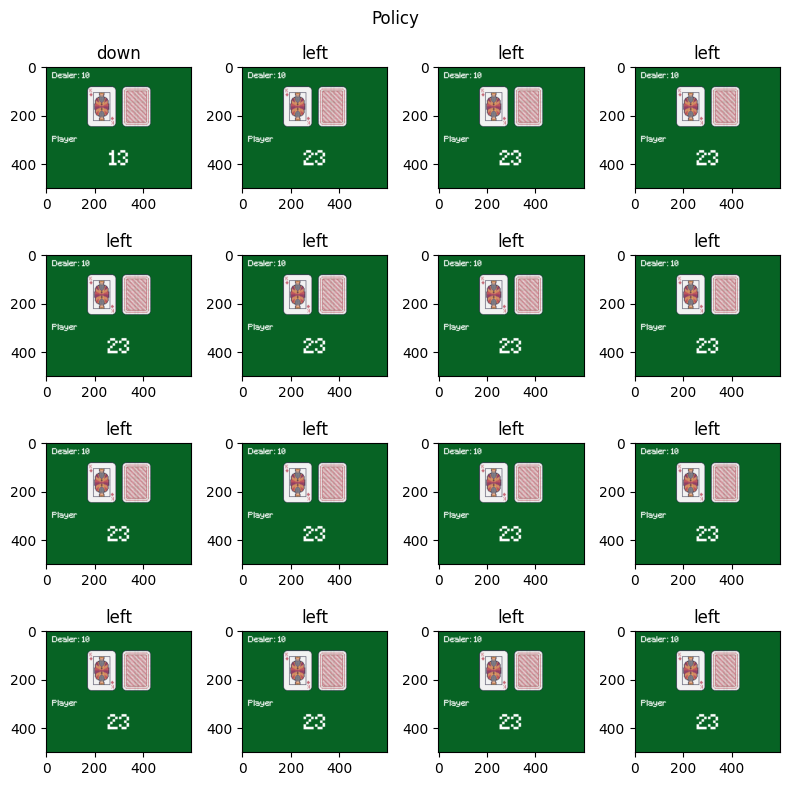

In [25]:
fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(8, 8))

obs, info = env_stat.reset()
done = False
for i in range(4):
    for j in range(4):
        img=env_stat.render()
        axs[i,j].imshow(img)
        
        action = agent1.get_action(obs)
        if action==0:
            axs[i,j].set_title("left")
        if action==1:
            axs[i,j].set_title("down")
        if action==2:
            axs[i,j].set_title("right")
        if action==3:
            axs[i,j].set_title("up")
        next_obs, reward, terminated, truncated, info = env_stat.step(action)
        #agent1.update(obs, action, reward, terminated, next_obs)
        done= terminated or truncated
        obs=next_obs
plt.suptitle('Policy') 
plt.tight_layout()
plt.show()